In [1]:
import numpy as np
import sys 
sys.path.append('../')
import copy
from PIL import Image
import open3d as o3d
import matplotlib.pyplot as plt
from magpie.perception import pcd
from open3d.web_visualizer import draw

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Open3D INFO] Resetting default logger to print to terminal.


The Puropose of this notebook is to integrate the current state of block-task with advancements made in hte open-grasp pipeline,
Specifically, the integration of the OVIT-SAM perception pipeline

In [2]:
from magpie import realsense_wrapper as real
rsc = real.RealSense()
rsc.initConnection()

In [3]:
from magpie.perception.label_owlvit import LabelOWLViT
path = "google/owlvit-base-patch32"
label_vit = LabelOWLViT(path)

In [11]:
from magpie.perception.mask_sam import MaskSAM
ckpt = "/home/streck/work/owlvit_segment_anything/sam_vit_h_4b8939.pth"
mask_sam = MaskSAM(ckpt)

In [115]:
p, rgbd_image = rsc.getPCD()
import cv2
image = np.array(rgbd_image.color)

high_contrast = cv2.convertScaleAbs(image, alpha=2.5, beta=-100) # 2.4 and -100 were the best 
image2= high_contrast

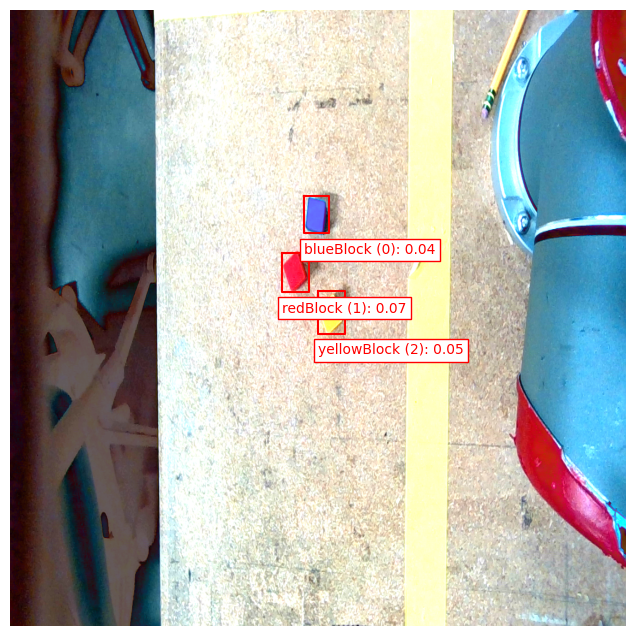

In [116]:




queries = ["a photo of a red cube", "a photo of a yellow cube", "a photo of a blue cube"]

abbrevq = ["redBlock", "yellowBlock", "blueBlock"]
label_vit.set_threshold(0.03)
bboxes, uboxes = label_vit.label(image2, queries, abbrevq, plot=True)

In [11]:
index = 1
# this does the [x, y, z] --> [y, -x, z] grasp pose switch, and the -y inversio on the y-axis orientation
# rgbd_image, cpcd, tmat = pcd.get_segment(label_vit.boxes, index, rgbd_image, rsc, type="box", display=False)
rgbd_image, cpcd, tmat = pcd.get_segment(label_vit.boxes, 
                                         index, 
                                         rgbd_image, 
                                         rsc, 
                                         type="box-dbscan", 
                                        #  type="box", 
                                        #  method="quat", 
                                         method="iterative", 
                                         display=True)
tmat, tmat[:3, 3]

z-axis dot product: [0.73346649]
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
FEngine (64 bits) created at 0x7f3d2c009f80 (threading is enabled)
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
EGL(1.5)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
OpenGL(4.1)


WebVisualizer(window_uid='window_0')

(array([[ 0.70644042, -0.25993852, -0.6583114 , -0.02903208],
        [-0.19754636, -0.96556844,  0.16927201,  0.03252445],
        [ 0.67964503, -0.01046643,  0.73346649,  0.36584986],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([-0.02903208,  0.03252445,  0.36584986]))

In [9]:
mobb = cpcd.get_minimal_oriented_bounding_box()
obb = cpcd.get_oriented_bounding_box()
mobb.extent, obb.extent

(array([0.02532031, 0.02656659, 0.01855757]),
 array([0.03668643, 0.0297738 , 0.01929771]))

In [12]:

# Segmentation Masks
mask_sam.set_image_and_labels(np.array(rgbd_image.color), np.array([np.array(i[0]) for i in label_vit.boxes]), label_vit.labels)

In [15]:
import rtde_control
import rtde_receive
from Motor_Code import Motors
import UR5_Interface as ur
import RealSense as real
import ObjectDetection as ob
import TaskPlanner as tp
import Block as bl
ur = ur.UR5_Interface()
robotIP = "192.168.0.6"
con = rtde_control.RTDEControlInterface(robotIP)
rec = rtde_receive.RTDEReceiveInterface(robotIP)
servoPort = "/dev/ttyACM0"
gripperController = Motors(servoPort)
gripperController.torquelimit(600) # used to be 600
gripperController.speedlimit(100)
ur.gripperController = gripperController
try:
    ur.c = con
    ur.r = rec
    ur.gripperController = gripperController
except Exception as e:
    raise(e)
else:
    print("UR5 + Gripper Interface Established")

RuntimeError: One of the RTDE input registers are already in use! Currently you must disable the EtherNet/IP adapter, PROFINET or any MODBUS unit configured on the robot. This might change in the future.

In [28]:
masks = mask_sam.get_masks(label_vit.labels)
depthImage,colorImage = rgbd_image.depth,rgbd_image.color
print(label_vit.labels)
print(np.array(masks))


['yellowBlock' 'redBlock' 'blueBlock']
[[[[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]


 [[[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]


 [[[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]]


In [35]:
urPose = ur.getPose()
print(urPose)
def getIndex(lables,name):
    for i in range(0, len(lables)):
        if lables[i] == name:
            return i

def getBlocksFromImages(lable_vit,colorImage, depthImage, urPose, display=False):
    # :colorImage 3-channel rgb image as numpy array
    # :depthImage 1-channel of measurements in z-axis as numpy array
    # :display boolean that toggles whether masks should be shown with color image
    # :urPose 4x4 numpy array or SE3 transform that is the pose of the Nth frame when the images were taken
    # colorImage,depthImage = RGBD_Image.color,RGBD_Image.depth
    # Returns a tuple of (RedPCD,yellowPCD,bluePCD) corresponding to each block class

    # Detects and segments classes using trained yolov8l-seg model
    # Inference step, only return instances with confidence > 0.6

    masks = mask_sam.get_masks(label_vit.labels)

    redMask = masks[getIndex(label_vit.labels,"redBlock")]
    yellowMask = masks[getIndex(label_vit.labels,"yellowBlock")]
    blueMask = masks[getIndex(label_vit.labels,"blueBlock")]

    '''
    if display:
        print("Color Image")
        plt.imshow(colorImage)
        plt.show()
        print("Red Mask")
        plt.imshow(redMask * 255,cmap = 'gray')
        plt.show()
        print("Yellow Mask")
        plt.imshow(yellowMask * 255,cmap = 'gray')
        plt.show()
        print("Blue Mask")
        plt.imshow(blueMask * 255, cmap = 'gray')
        plt.show()
    '''
    if display:
        fig, ax = plt.subplots(2, 1)
        print("Color Image and Depth Image")
        ax[0].imshow(colorImage)
        ax[0].set_title("Color Image")
        ax[1].imshow(depthImage)
        ax[1].set_title("Depth Image")
        plt.show()

        print("Masks")
        fig, ax = plt.subplots(3, 1)
        ax[0].imshow(redMask[0] * 255, cmap='gray')
        ax[0].set_title("Red Mask")
        ax[1].imshow(yellowMask[0] * 255, cmap='gray')
        ax[1].set_title("Yellow Mask")
        ax[2].imshow(blueMask[0] * 255, cmap='gray')
        ax[2].set_title("Blue Mask")
        plt.show()

    redDepthImage = np.multiply(depthImage, np.array(redMask).astype(int)).astype('float32')
    yellowDepthImage = np.multiply(depthImage, np.array(yellowMask).astype(int)).astype('float32')
    blueDepthImage = np.multiply(depthImage, np.array(blueMask).astype(int)).astype('float32')

    print(redDepthImage)

    # SEGMENT PCD INTO RED,YELLOW,BLUE BLOCKS
    depthScale = rsc.depthScale

    # Create Segmented RGBD Images for Each Color
    redRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(colorImage),
        o3d.geometry.Image(redDepthImage[0]),
        convert_rgb_to_intensity=False,
        depth_scale=1
    )

    yellowRGDB_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(colorImage),
        o3d.geometry.Image(yellowDepthImage[0]),
        convert_rgb_to_intensity=False,
        depth_scale=1
    )

    blueRGBD_Image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(colorImage),
        o3d.geometry.Image(blueDepthImage[0]),
        convert_rgb_to_intensity=False,
        depth_scale=1
    )
    # Create Point Clouds for Each Class
    redPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        redRGDB_Image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True
    )
    yellowPCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        yellowRGDB_Image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True
    )
    bluePCD = o3d.geometry.PointCloud.create_from_rgbd_image(
        blueRGBD_Image,
        rsc.pinholeInstrinsics,
        project_valid_depth_only=True
    )
    '''
    # Downsample point cloud's based on realsense voxel_size parameter
    redPCD = redPCD.voxel_down_sample(voxel_size=self.real.voxelSize)
    yellowPCD = yellowPCD.voxel_down_sample(voxel_size=self.real.voxelSize)
    bluePCD = bluePCD.voxel_down_sample(voxel_size=self.real.voxelSize)
    '''
    redPCD.paint_uniform_color([1, 0, 0])
    yellowPCD.paint_uniform_color([1, 1, 0])
    bluePCD.paint_uniform_color([0, 0, 1])

    # o3d.visualization.draw([redPCD,yellowPCD,bluePCD])
    # o3d.visualization.draw_geometries([redPCD,yellowPCD,bluePCD])
    redBlock = bl.Block("redBlock", redPCD, urPose)
    yellowBlock = bl.Block("yellowBlock", yellowPCD, urPose)
    blueBlock = bl.Block("blueBlock", bluePCD, urPose)
    return (redBlock, yellowBlock, blueBlock)


  -0.02898  -0.9589   -0.2824   -0.2491    
  -0.9996    0.02803   0.007418 -0.1292    
   0.0008006  0.2824   -0.9593    0.2455    
   0         0         0         1         



Color Image and Depth Image


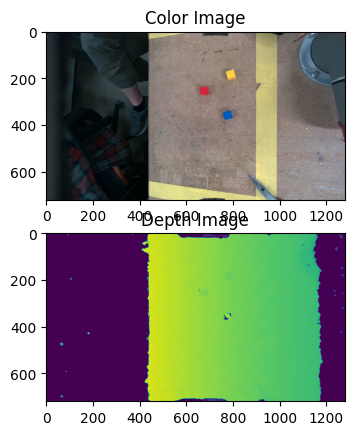

Masks


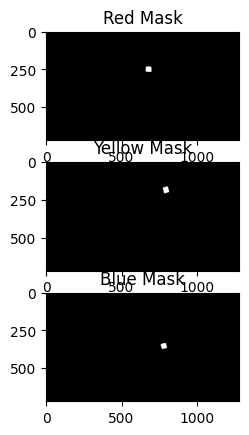

[[[          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  ...
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]
  [          0           0           0 ...           0           0           0]]]
[(1319, PointCloud with 1319 points.)]
[(1393, PointCloud with 1393 points.)]
[(1009, PointCloud with 1009 points.)]


In [37]:
blocks = getBlocksFromImages(lable_vit, colorImage, depthImage, urPose, display=True)



In [38]:
planner = tp.TaskPlanner(blocks)
goalDict = {"on":[("blueBlock","yellowBlock")]}
steps = planner.generatePlan(goalDict)
print(steps)
for block in blocks:
    print(f"{block.name} - {list(block.gripperFrameCoords)}")

redBlock: [    -394.55     -57.619     -316.09]
yellowBlock: [    -321.82     -22.788     -315.84]
blueBlock: [    -333.11     -125.69     -338.79]
we got here
<<INITIAL WORLD STATE>>
on(yellowBlock,blueBlock)
clear(yellowBlock)
on(blueBlock,loc-a)
on(redBlock,loc-c)
clear(redBlock)
fixed(loc-a)
fixed(loc-b)
clear(loc-b)
fixed(loc-c)
Domain PDDL written to domain.pddl.
Problem PDDL written to problem.pddl.
<<RUNNING FASTDOWNWARD PLANNER>>
<<PLANNER OUTPUT>>
Action: move
objectToMove: blueBlock
To: yellowBlock
Pickup blueBlock at [ -0.0015114   -0.084324     0.47174]
Release on object yellowBlock at position [   -0.10467   -0.085785     0.44731]
Action: move
objectToMove: redBlock
To: yellowBlock
Pickup redBlock at [   -0.06775   -0.017096     0.46782]
Release on object yellowBlock at position [   -0.10467   -0.085785     0.44731]
[(array([ -0.0015114,   -0.084324,     0.47174]), array([   -0.10467,   -0.085785,     0.44731])), (array([   -0.06775,   -0.017096,     0.46782]), array([   

sh: 1: /home/andreamiller/ris/downward/fast-downward.py: not found
